# Homework 2
Corte Pause Manuela 240183

Marrocco Simone 239951

## Exercise 1

p-value for Kolmogorov Smirnoff test: 0.0
CoV: 1.1815
Jain: 0.4174
Lorenz: 0.4071
Lorenz computed using the graphical representation: 0.4071


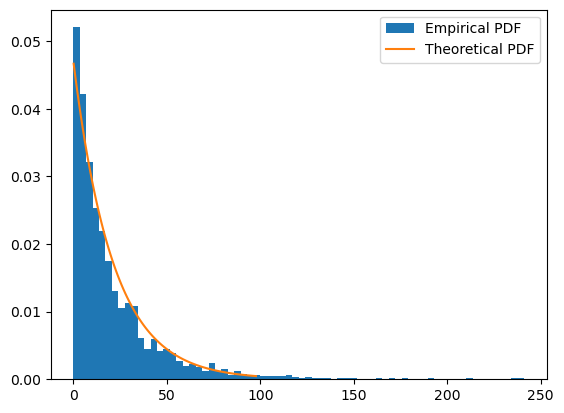

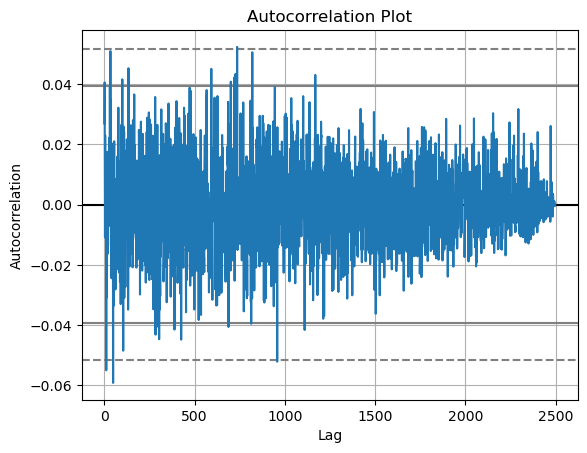

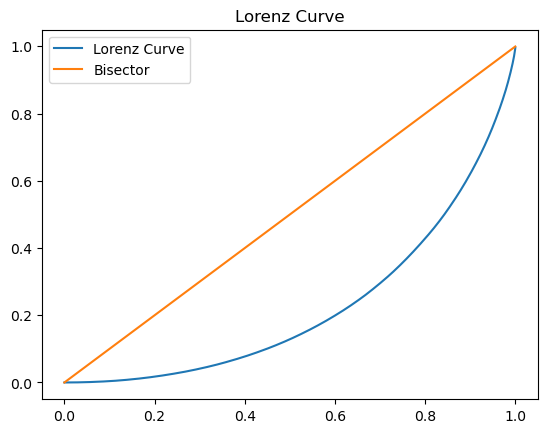

In [1]:
import pandas as pd
import pandas.plotting as pd_plot
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


def calculate_cov(data):
    return np.std(data)/np.mean(data)


def calculate_jain_index(data):
    mean = np.mean(data)
    sd = np.std(data)
    return 1/(1+np.square(sd/mean))


def calculate_lorenz_index(data):
    mean = np.mean(data)
    mad = np.sum(np.abs(data - mean)) / len(data)
    return mad/(2*mean)


gen = np.random.default_rng(seed=41)

df = pd.read_csv('data_ex1.csv')
data = np.array(df.values).flatten()

# Data looks exponentiallt distributed
# We want to check it by plotting the histogram of the data and the pdf of an exponential with lambda=1/sample_mean.
f, ax = plt.subplots(1)
ax.hist(data, bins='auto', density=True, label='Empirical PDF')
exp = stats.expon(scale=np.mean(data))
x = np.linspace(exp.ppf(0.01), exp.ppf(0.99), 100)
ax.plot(x, exp.pdf(x), label='Theoretical PDF')
ax.legend()

# Even if a lack of autocorrelation does not necessarly imply independence, it is a good indicator that our data are independent anyway.
f, ax = plt.subplots(1)
pd_plot.autocorrelation_plot(df, ax=ax)
ax.set_title('Autocorrelation Plot')

# Our data looks a bit more heavy tailed than an exponential distributed
# We use the Kolmogorov-Smirnov test to get more statistically significant results.
ks = stats.kstest(data, stats.expon.cdf, args=(np.mean(data),))
# The p-value is very low, so we can reject the null hypothesis that the data is exponentially distributed.
print(f'p-value for Kolmogorov Smirnoff test: {ks.pvalue}')


mean = np.mean(data)
sd = np.std(data)
n = len(data)
cov = calculate_cov(data)
jain = calculate_jain_index(data)
lorenz = calculate_lorenz_index(data)

# We can plot the Lorenz curve and the bisector to get a graphical representation of unfairness of the dataset.
sorted_data = np.sort(data)
x = [i/n for i in range(n)]
li = [np.sum(sorted_data[:i])/(np.sum(sorted_data)) for i in range(n)]
f, ax = plt.subplots(1)
ax.plot(x, li, label='Lorenz Curve')
ax.plot(x, x, label='Bisector')
ax.set_title('Lorenz Curve')
ax.legend()

# The Jain fair index and the Lorenz gap are quite similar as they are both a measure of fairness of the dataset in the interval [0,1].
# The Lorenz curve gap is usually to be prefered as it is well defined even for heavy tailed distributions while the Jain index is not as
# it is based on the coefficient of variation which doesn't exist if the variance is infinite.
print(f'CoV: {cov:.{4}f}')
print(f'Jain: {jain:.{4}f}')
print(f'Lorenz: {lorenz:.{4}f}')

# As an additional check we can compute the Lorenz curve gap as the max distance between the Lorenz curve and the bisector.
lorenz_graph = np.max(np.array(x) - np.array(li))
print(
    f'Lorenz computed using the graphical representation: {lorenz_graph:.{4}f}')


In [2]:
def bootstrap_algorithm(data, r0, gamma, fn):
    R = int(np.ceil(2*r0/(1-gamma)) - 1)
    T = []
    for _ in range(R):
        sample = gen.choice(data, size=n, replace=True)
        T.append(fn(sample))
    T = sorted(T)
    return (round(T[r0], 4), round(T[R+1-r0], 4))

# Organizing the functions like this allows us to easily change the statistic we want to compute the confidence interval for.
def bootstrap_mean(data, r0, gamma):
    return bootstrap_algorithm(data, r0, gamma, np.mean)


def bootstrap_sd(data, r0, gamma):
    return bootstrap_algorithm(data, r0, gamma, np.std)


def bootstrap_cov(data, r0, gamma):
    return bootstrap_algorithm(data, r0, gamma, calculate_cov)


def bootstrap_jain(data, r0, gamma):
    return bootstrap_algorithm(data, r0, gamma, calculate_jain_index)


def bootstrap_lorentz(data, r0, gamma):
    return bootstrap_algorithm(data, r0, gamma, calculate_lorenz_index)


r0 = 25
print(f'r0 = {r0}')

print('Number of samples: ', n)
print('Statistic \t CI 95% \t\t CI 99%')

ci_mean_95 = bootstrap_mean(data, r0, 0.95)
ci_mean_99 = bootstrap_mean(data, r0, 0.99)
print(f'Mean:{mean: .4f} \t {ci_mean_95} \t {ci_mean_99}')

ci_sd_95 = bootstrap_sd(data, r0, 0.95)
ci_sd_99 = bootstrap_sd(data, r0, 0.99)
print(f'SD:{sd: .4f} \t {ci_sd_95} \t {ci_sd_99}')

ci_cov_95 = bootstrap_cov(data, r0, 0.95)
ci_cov_99 = bootstrap_cov(data, r0, 0.99)
print(f'CoV:{cov: .4f} \t {ci_cov_95} \t {ci_cov_99}')

ci_lorentz_95 = bootstrap_lorentz(data, r0, 0.95)
ci_lorentz_99 = bootstrap_lorentz(data, r0, 0.99)
print(f'Lor:{lorenz: .4f} \t {ci_lorentz_95} \t {ci_lorentz_99}')

ci_jain_95 = bootstrap_jain(data, r0, 0.95)
ci_jain_99 = bootstrap_jain(data, r0, 0.99)
print(f'Jain:{jain: .4f} \t {ci_jain_95} \t {ci_jain_99}')

print('CIs for mean: Asymptotic case')
print(f'Statistic \t CI 95% asym \t\t CI 99% asym')

# The asymptotic CIs are a bit smaller tha the ones computed using the bootstrap.
# This is probably due to the fact that the asymptotic CIs have the additional assumption that the data is normally distributed
# while the bootstrap CIs only assume that the data is i.i.d.
# This normality assumption gives us more information about the distribution of the data and thus allows us to compute smaller CIs.


def eta_ci(n, mean, sd, level):
    eta = stats.norm.ppf(level)
    return (round(mean - eta*sd/np.sqrt(n), 4), round(mean + eta*sd/np.sqrt(n), 4))


ci_mean_95_asym = eta_ci(n, mean, sd, 0.95)
ci_mean_99_asym = eta_ci(n, mean, sd, 0.99)
print(f'Mean:{mean: .4f} \t {ci_mean_95_asym} \t {ci_mean_99_asym}')

# As a check we can compute the CIs using the function provided by scipy.
ci_mean_theoretical_lower, ci_mean_theoretical_upper = stats.norm.interval(
    [0.95, 0.99], loc=mean, scale=sd/np.sqrt(n))
ci_mean_95_theoretical = (round(ci_mean_theoretical_lower[0], 4), round(
    ci_mean_theoretical_upper[0], 4))
ci_mean_99_theoretical = (round(ci_mean_theoretical_lower[1], 4), round(
    ci_mean_theoretical_upper[1], 4))
print('CI for mean: Theoretical case')
print('Statistic \t CI 95% theoretical \t CI 99% theoretical')
print(f'Mean:{mean: .4f} \t {ci_mean_95_theoretical}, \t {ci_mean_99_theoretical}')


r0 = 25
Number of samples:  2499
Statistic 	 CI 95% 		 CI 99%
Mean: 21.2175 	 (20.2217, 22.2222) 	 (19.9555, 22.4701)
SD: 25.0686 	 (23.2775, 27.1221) 	 (22.7244, 27.6594)
CoV: 1.1815 	 (1.1293, 1.235) 	 (1.1085, 1.2613)
Lor: 0.4071 	 (0.397, 0.4172) 	 (0.3938, 0.4208)
Jain: 0.4174 	 (0.3938, 0.4409) 	 (0.388, 0.4499)
CIs for mean: Asymptotic case
Statistic 	 CI 95% asym 		 CI 99% asym
Mean: 21.2175 	 (20.3927, 22.0424) 	 (20.051, 22.3841)
CI for mean: Theoretical case
Statistic 	 CI 95% theoretical 	 CI 99% theoretical
Mean: 21.2175 	 (20.2347, 22.2004), 	 (19.9258, 22.5093)


## Exercise 2

Statistic 	 CI 99%
Mean: 0.1433 	 (-0.0108, 0.297)
Std: 2.9650 	 (2.8314, 3.0976)


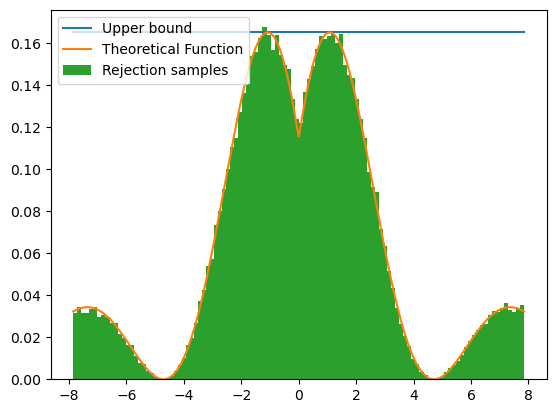

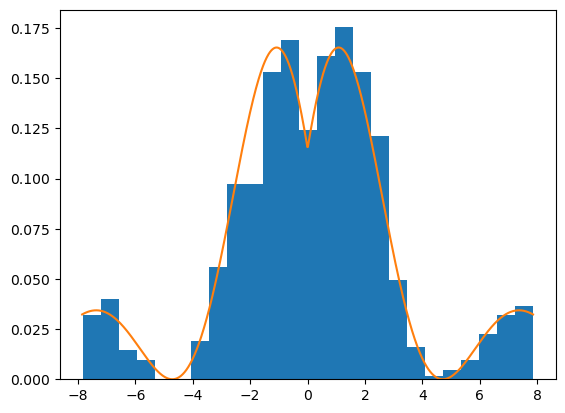

In [3]:
a = -5*np.pi/2
b = 5*np.pi/2

# Rejection sampling is a general method that can be used to sample from any function f(x) in the interval [a, b] with upper bound M
# it doesn't require the function to be a probability density function so we could have used it even without A
A = 8.69336125  # normalization constant


def f(x):
    if x >= a and x <= b:
        return 1/A * np.exp(-np.abs(x)/4) * (np.sin(np.abs(x))+1)
    else:
        raise Exception('x out of range')


def rejection_sampling(M, n_samples):
    i = 0
    samples = []
    while i < n_samples:
        x = gen.uniform(a, b)
        u = gen.uniform(0, M)
        if u <= f(x):
            samples.append(x)
            i += 1
    return samples


x = np.linspace(a, b, 1000)
y = []
for i in x:
    y.append(f(i))

M = np.max(y)
# print(M)

# We do rejection sampling of the function f in the interval [a, b] with upper bound M
# 100000 is a big enough number to get a good approximation of the distribution
n_samples = 100000
samples = rejection_sampling(M, n_samples)

_, ax = plt.subplots(1)
ax.plot(x, np.ones(len(x)) * M, label='Upper bound')
ax.plot(x, y, label='Theoretical Function')
y_hist, x_hist, _ = ax.hist(
    samples, bins='auto', density=True, label='Rejection samples')
ax.legend(loc='upper left')
# print(f'Max theoretical value: {M}, max value in samples: {np.max(y_hist)}')

# Test with a million samples, more precise but takes longer to run and 100000 is already good enough of an approximation
# n_samples = 1000000
# samples = rejection_sampling(M, n_samples)
# _, ax = plt.subplots(1)
# ax.plot(x, np.ones(len(x)) * M)
# ax.plot(x, y)
# y_hist, x_hist, _ = ax.hist(samples, bins='auto', density=True)

# Since the replacement already happens when computing the bootstrap CIs, the replacement here is not necessary
subsample = gen.choice(samples, size=1000, replace=False)
_, ax = plt.subplots(1)
ax.hist(subsample, bins='auto', density=True, label='Subsample')
ax.plot(x, y, label='Theoretical Function')
print(f'Statistic \t CI 99%')
mean_ci_99 = bootstrap_mean(subsample, r0, 0.99)
print(f'Mean: {np.mean(subsample):.4f} \t {mean_ci_99}')
std_ci_99 = bootstrap_sd(subsample, r0, 0.99)
print(f'Std: {np.std(subsample):.4f} \t {std_ci_99}')

# Test to see if the CIs are the same for the subsample and the whole sample (slightly smaller because of larger sample size)
# mean_ci_99_total = bootstrap_mean(samples, r0, 0.99)
# print(f'Mean: {np.mean(samples):.4f} \t {mean_ci_99_total}')


# Exercise 3

Percentile 	 CI 95% 		 CI 95% bootstrap
10%: -5.3824 	 (-5.4035, -5.3566) 	 (-5.4238, -5.3351)
25%: -5.0121 	 (-5.03, -4.9973) 	 (-5.0449, -4.9811)
50%: -3.8768 	 (-3.9763, -3.7929) 	 (-4.1191, -3.7074)
75%: -2.5142 	 (-2.5591, -2.4511) 	 (-2.5987, -2.4101)
90%: -1.7130 	 (-1.739, -1.6778) 	 (-1.7827, -1.6565)


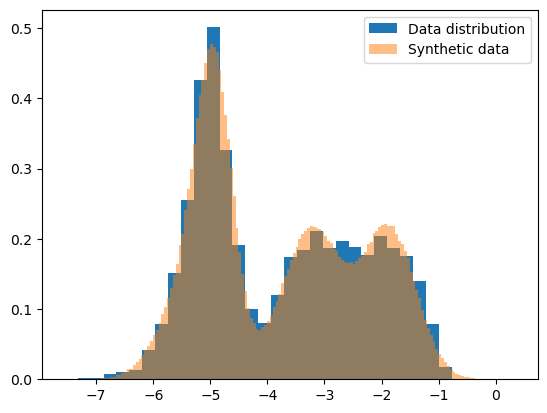

In [4]:
from sklearn.mixture import GaussianMixture
data = np.loadtxt('data_ex3.csv', delimiter=',', dtype=float)
data = np.sort(data)


# We have enough datapoints to use the approximate formula for the quantile confidence interval
def quantile_ci(data, p, gamma):
    eta = stats.norm.ppf((1+gamma)/2)
    n = len(data)
    j = int(np.floor(n*p - eta*np.sqrt(n*p*(1-p))))
    k = int(np.ceil(n*p + eta*np.sqrt(n*p*(1-p))) + 1)
    return (round(data[j], 4), round(data[k], 4))

# Another possible way to compute the confidence intervals in using bootstrap since the only requirement is for data to be i.i.d.


def bootstrap_quantile(data, p, r0, gamma):
    R = int(np.ceil(2*r0/(1-gamma)) - 1)
    T = []
    for i in range(R):
        sample = gen.choice(data, size=n, replace=True)
        T.append(np.quantile(sample, p))
    T = sorted(T)
    return (round(T[r0], 4), round(T[R+1-r0], 4))

# Function to compactly compute the CIs for the different percentiles


def calculate_percentile(data, percentile, level):
    percentile_value = np.quantile(data, percentile)
    percentile_value_ci = quantile_ci(data, percentile, level)
    percentile_value_ci_bootstrap = bootstrap_quantile(
        data, percentile, 25, level)
    return percentile_value, percentile_value_ci, percentile_value_ci_bootstrap


print(f'Percentile \t CI 95% \t\t CI 95% bootstrap')
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for percentile in percentiles:
    percentile_value, percentile_value_ci, percentile_value_ci_bootstrap = calculate_percentile(
        data, percentile, 0.95)
    print(f'{int(percentile*100)}%: {percentile_value: .4f} \t {percentile_value_ci} \t {percentile_value_ci_bootstrap}')

# Simple histogram of the data to get an idea of the distribution (probably a superimpose of multiple distributions)
# We also try to find the parameters of the underlying distribution using GMM not very good since we are training on the whole dataset
# instead of splitting it into training and test set but it's just to get a general idea

gen.shuffle(data)
gm = GaussianMixture(n_components=4, random_state=11).fit(data.reshape(-1, 1))
# print(gm.means_)
# print(gm.covariances_)
synth_data = gm.sample(1000000)
f, ax = plt.subplots(1)
ax.hist(data, bins='auto', density=True, label='Data distribution')
ax.hist(synth_data[0], bins='auto', alpha=0.5,
        density=True, label='Synthetic data')
ax.legend()
plt.show()
